# Session 2: Linear regression, classification, k-Nearest Neighbors

In this session, we will introduce the task of linear regression, the simplest type of machine learning problem. From there, we will learn about classification, and look at a naive way of doing it using a method called k-Nearest Neighbors.


?-> neural nets

## Linear Regression

We are first going to introduce a the most basic machine learning problem, that of fitting a line to a set of points.  Consider the following dataset:

In [1]:
import numpy as np

data = np.array([
    [2.4, 1.7], 
    [2.8, 1.85], 
    [3.2, 1.79], 
    [3.6, 1.95], 
    [4.0, 2.1], 
    [4.2, 2.0], 
    [5.0, 2.7]
])

We have a series of {x,y} pairs. We can plot them with a scatterplot.

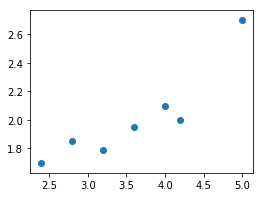

In [3]:
import matplotlib.pyplot as plt

x, y = data[:,0], data[:,1]

plt.figure(figsize=(4, 3))
plt.scatter(x, y)

The goal of linear regression is to find a line, $y = mx + b$ which fits the data points as well as possible. 

What does it mean for it to fit the points "as well as possible"? Let's try three random lines and compare them.  We will define the following three functions as candidates:

$$f1(x) = 0.92x-1.0$$
$$f2(x) = -0.21x+3.4$$
$$f3(x) = 0.52x+0.1$$

In [28]:
def f1(x):
    return 0.92 * x - 1.0

def f2(x):
    return -0.21 * x + 3.4

def f3(x):
    return 0.52 * x + 0.1

# try some examples
print("f1(-1.0) = %0.2f" % f1(-1))
print("f2( 0.0) = %0.2f" % f2(0))
print("f3( 2.0) = %0.2f" % f3(2))

f1(-1.0) = -1.92
f2( 0.0) = 3.40
f3( 2.0) = 1.14


Let's plot all three of these functions and see how well each of them fit the points in our dataset.

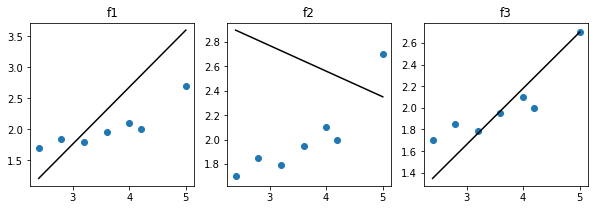

In [29]:
min_x, max_x = min(x), max(x)

fig = plt.figure(figsize=(10,3))

fig.add_subplot(131)
plt.scatter(x, y)
plt.plot([min_x, max_x], [f1(min_x), f1(max_x)], 'k-')
plt.title("f1")

fig.add_subplot(132)
plt.scatter(x, y)
plt.plot([min_x, max_x], [f2(min_x), f2(max_x)], 'k-')
plt.title("f2")

fig.add_subplot(133)
plt.scatter(x, y)
plt.plot([min_x, max_x], [f3(min_x), f3(max_x)], 'k-')
plt.title("f3")

Intuitively, it looks like $f1$ and $f3$ come closest to a good fit, with $f3$ looking somewhat better than $f1$, and $f2$ showing the worst fit. But how do we formally express how good a fit is? We define a "cost" function which expresses the total error between the points predicted by the line, and those of the actual dataset.

One very popular measure of this called the "mean squared error," which we will denote as $J$, which is the average of the square differences between the data points and the line. Another name for MSE is the "L2-distance." 

$$ J = \frac{1}{n} \sum_i{(y_i - f(x_i))^2} $$

Intuitively, for each pair of points $(x_i, y_i)$, the quantity $y_i - f(x_i)$ is the difference between the actual point $y_i$ and the y-value predicted by the line at $x_i$. Then we square them  (to penalize large distances more) and average them by diving by $n$, which is the number of samples in the dataset. 

Since the function $f(x_i) = m x_i + b$, we can substitute that into the error, and get:

$$ J = \frac{1}{n} \sum_i{(y_i - (mx_i + b))^2} $$


In [30]:
def MSE(y_pred, y_actual):
    n = np.size(y_pred)
    return (1.0 / n) * np.sum((y_actual-y_pred)**2)


In [31]:
x, y = data[:,0], data[:,1]

J1 = MSE(f1(x), y)
J2 = MSE(f2(x), y)
J3 = MSE(f3(x), y)

print("J1=%0.2f, J2=%0.2f, J3=%0.2f" % (J1, J2, J3))

J1=0.34, J2=0.62, J3=0.04


As we expected, the third function has the lowest error rate.

What is a good method for finding the optimal $m$ and $b$ to get the lowest error rate? The naive way would be to simply have the computer make millions of guesses like this and keep the one that happens to have the best error rate. Computers are pretty fast, so why not? For our simple problem with two parameters, this would work fine. But in real-world scenarios, we are often dealing with dozens, hundreds, or even millions of parameters which have to be optimized at the same time. Making guesses does not scale to a large number of dimensions. No computer is fast enough to try enough guesses to get a reasonable answer.

So we need a more formal method for this. We can get an idea of how we might do this by first observing the loss surface. We'll plot the MSE of every combination of $m$ and $b$ within some range and look at it first. Note: recall that for this toy problem, calculating MSE for all combinations of our two parameters is easy to do because there'sa small number of combinations. In problems where we have thousands or more parameters, it will be infeasible to do this practically because there will be too many parameter combinations to try (which is the reason we need a better method than brute force guessing to begin with). For 2 parameters, we observe the loss surface just for demonstration purposes.


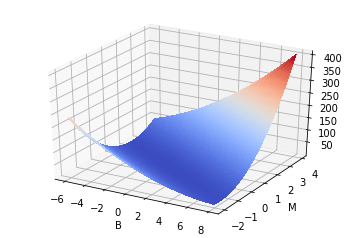

In [41]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

# check all combinations of m between [-4, 4] and b between [-4, 4], to precision of 0.1
M = np.arange(-2, 4, 0.1)
B = np.arange(-6, 8, 0.1)

# get MSE at every combination
J = np.zeros((len(M), len(B)))
for i, m_ in enumerate(M):
    for j, b_ in enumerate(B):
        J[i][j] = MSE(m_*x+b_, y)

# plot loss surface
B, M = np.meshgrid(B, M)
ax.plot_surface(B, M, J, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
plt.xlabel("B")
plt.ylabel("M")

Our loss surface looks a bit like an elongated bowl. Because our goal is to find the parameters $m$ and $b$ which give us the lowest possible error, this translates to finding the point at the bottom of that bowl. By eye, it looks like it's roughly around $m=0, b=2$. 

### Gradient descent

Let's now define a better method for actually finding this point. The method we are going to introduce is called "gradient descent." Note, there is a much easier way to do linear regression than to use gradient descent, but we will use gradient descent anyway, because later on, when we introduce neural networks, we shall see that gradient descent is the best way by which to find the optimal parameters for them. So we introduce gradient descent in the context of a simple problem first.

Gradient descent will be discussed in more detail in the next two sessions. To get ahead, you can read [this ml4a chapter](https://ml4a.github.io/ml4a/how_neural_networks_are_trained/) for a more thorough introduction.

The basic idea behind gradient descent is as follows. Start with a random guess about the parameters, and then calculate the gradient of the loss function with respect to the parameters. Recall from the previous session that the gradient of a function is the vector containing each of the partial derivatives of its variables, i.e.

$$
\nabla f(X) = \left[ \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, ..., \frac{\partial f}{\partial x_n}  \right]
$$

Our loss function $J$ has two parameters: the slope $m$ and y-intercept $b$. Thus its gradient is:

$$
\nabla J = \left[ \frac{\partial J}{\partial m}, \frac{\partial J}{\partial b} \right]
$$

The interpretation of the gradient is that it gives us the slope in every dimension of the loss function at any $m$ and $b$. What gradient descent does is it evaluates the slope of the loss function at the current parameters, and then takes a small step in the exact opposite direction (because the slope is upward). This has the effect of moving $m$ and $b$ to a place where the error is a bit lower than it was before. Repeat this process many times until the loss stops descending (because we have reached the bottom) and you are finished. This is the basic idea.

How can we actually calculate the partial derivatives: $\frac{\partial J}{\partial m}$ and $\frac{\partial J}{\partial b}$? We must differentiate $J$ with respect to these two parameters.

Recall:

$$ J(m,b) = \frac{1}{n} \sum_i{(y_i - (mx_i + b))^2} $$

Let's start with $\frac{\partial J}{\partial m}$. We can derive its partial derivative with the following steps:

$$ \frac{\partial J}{\partial m} = \frac{\partial}{\partial m} \begin{bmatrix} \frac{1}{n} \sum_i{(y_i - (mx_i + b))^2} \end{bmatrix}  $$ 

$$ \frac{\partial J}{\partial m} =  \frac{1}{n} \sum_i{ \frac{\partial}{\partial m} (y_i - (mx_i + b))^2}  $$ 

$$ \frac{\partial J}{\partial m} =  \frac{1}{n} \sum_i{ -2 x_i \cdot (y_i - (mx_i + b))}  $$ 

$$ \frac{\partial J}{\partial m} = -\frac{2}{n} \sum_i{x_i \cdot (y_i - (mx_i + b))} $$

For $\frac{\partial J}{\partial b}$, the partial derivative is found:

$$ \frac{\partial J}{\partial b} = \frac{\partial}{\partial b} \frac{1}{n} \sum_i{(y_i - (mx_i + b))^2}  $$ 

$$ \frac{\partial J}{\partial b} = \frac{1}{n} \sum_i{ \frac{\partial}{\partial b} (y_i - (mx_i + b))^2}  $$ 

$$ \frac{\partial J}{\partial b} = \frac{1}{n} \sum_i{ -2 \cdot (y_i - (mx_i + b))}  $$ 

$$ \frac{\partial J}{\partial b} = -\frac{2}{n} \sum_i{(y_i - (mx_i + b))} $$

So to summarize, we have found:

$$ \frac{\partial J}{\partial m} = -\frac{2}{n} \sum_i{x_i \cdot (y_i - (mx_i + b))} $$
$$ \frac{\partial J}{\partial b} = -\frac{2}{n} \sum_i{(y_i - (mx_i + b))} $$

We can then define the following update rule, where we calculate the gradient and then adjust the parameters $m$ and $b$:

$$ m := m - \alpha \cdot \frac{\partial J}{\partial m} $$

$$ b := b - \alpha \cdot \frac{\partial J}{\partial b} $$

Where $\alpha$ is a hyperparameter called the "learning rate" that controls the size of the update step. In simple gradient descent, the learning rate must be chosen manually, but as we shall seee later, there are more complex variants of gradient descent which automatically pick and adjust the learning rate during training. If we set $\alpha$ too high, we may overshoot the best trajectory, whereas if we set it too low, learning may take an unacceptably long time. Typical values of this are 0.01, 0.001, 0.0001 and so on.

Let's implement this in code:

initial parameters: m=0.800, b=-0.500
initial MSE = 2.088
final parameters: m=0.339, b=0.793
final MSE = 0.126


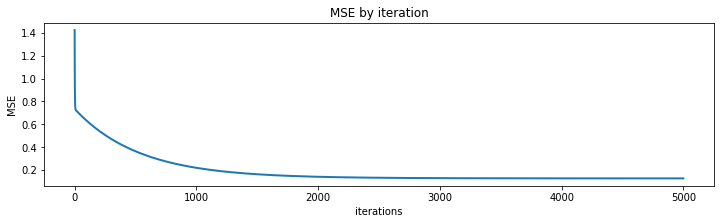

In [594]:
import random

# choose a random initial m, b
m, b = 0.8, -0.5

# what is our error?
init_mse = mse(m*x+b, y)

print("initial parameters: m=%0.3f, b=%0.3f"%(m, b))
print("initial MSE = %0.3f" % init_mse)

# implement partial derivatives of our parameters
# not len(y) should be shape data
def dJdm(data, m, b):
    x, y = data[:,0], data[:,1]
    return (-2.0 / len(y)) * np.dot(x, y - (m * x + b))

def dJdb(data, m, b):
    x, y = data[:,0], data[:,1]
    return (-2.0 / len(y)) * np.sum(y - (m * x + b))

# choose the alpha parameter and number of iterations
alpha = 0.01
n_iters = 5000

# keep track of error
errors = []
for i in range(n_iters):
    m = m - alpha * dJdm(data, m, b)
    b = b - alpha * dJdb(data, m, b)
    j = mse(m * x + b, y)
    #print(m, b, j)
    errors.append(j)
    
# plot it

plt.figure(figsize=(12, 3))
plt.plot(range(n_iters), errors, linewidth=2)
plt.title("MSE by iteration")
plt.ylabel("MSE")
plt.xlabel("iterations")

# what is our final error rate
final_mse = mse(m*x+b, y)

print("final parameters: m=%0.3f, b=%0.3f"%(m, b))
print("final MSE = %0.3f" % final_mse)


The procedure that we just demonstrated is called "gradient descent." It's not actually necessary to do linear regression, because linear regression can be solved analytically. However, in the next section we will introduce neural networks, which can not be optimized analytically, and thus will require gradient descent to train.

## Classification

Consider the following small dataset:

In [736]:
from IPython.display import HTML, display
import tabulate

# toy datast of whether or not it will be rainy or sunny
feature_names = ["Humidity (%)", "Pressure (kPa)"]
data = [[29, 101.7], [60, 98.6], [40, 101.1], [62, 99.9], [39, 103.2], [51, 97.6], [46, 102.1], [55, 100.2]]
labels = ["Sun","Rain","Sun","Rain","Sun","Rain","Sun","Rain"]

# display table
table_labels = np.array(['class']+feat_names).reshape((1, 1+len(feature_names)))
table_data = np.concatenate([np.array(labels).reshape(len(data), 1), data], axis=1)
table_full = np.concatenate([table_labels, table_data], axis=0)
display(HTML(tabulate.tabulate(table_full, tablefmt='html')))

class,Humidity (%),Pressure (kPa)
Sun,29.0,101.7
Rain,60.0,98.6
Sun,40.0,101.1
Rain,62.0,99.9
Sun,39.0,103.2
Rain,51.0,97.6
Sun,46.0,102.1
Rain,55.0,100.2


We can plot these points on a scatterplot. In the following, a `+` means "Rain" and a `-` is "Sun" (no rain).

![classification](http://ml4a.github.io/images/lin_classifier_2d.png)

Classification is defined as the task of predicting the correct label or category of an unknown point. With two classes, we divide the data space into two halves, one for each class. So when we receive a new point, we simply find which side of the partition the point is in.

![classification](http://ml4a.github.io/images/lin_classifier_2d_newpt.png)

## k-nearest neighbors classification

We will introduce a simple technique for classification called k-nearest neighbors classification (kNN). Before doing that, we are going to scale up our problem with a slightly more realistic dataset called [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set), which is commonly used to introduce data science tasks.

Iris is a dataset containing 150 samples of flowers of the Iris genus, belonging to three different species (Iris setosa, Iris virginica, Iris versicolor). The dataset records their species (which is the class label), along with the following features: Petal Length, Petal Width, Sepal Length, and Sepal width. 

In the next cell, we import the dataset, and shuffle it.

In [744]:
import numpy as np
from sklearn.datasets import load_iris

# load iris and grab our data and labels
iris = load_iris()
labels, data = iris.target, iris.data

num_samples = len(labels)  # size of our dataset
num_features = len(iris.feature_names)  # number of columns/variables

# shuffle the dataset
shuffle_order = np.random.permutation(num_samples)
data = data[shuffle_order, :]
labels = labels[shuffle_order]


Let's view a table showing the first 20 samples.

In [745]:
label_names = np.array([iris.target_names[l] for l in labels])
table_labels = np.array(['class']+iris.feature_names).reshape((1, 1+num_features))
class_names = iris.target_names
table_data = np.concatenate([np.array(label_names).reshape(num_samples, 1), data], axis=1)[0:20]

# display table
table_full = np.concatenate([table_labels, table_data], axis=0)
display(HTML(tabulate.tabulate(table_full, tablefmt='html')))


class,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
setosa,5.4,3.4,1.5,0.4
virginica,7.2,3.0,5.8,1.6
versicolor,6.6,2.9,4.6,1.3
virginica,6.8,3.0,5.5,2.1
virginica,6.4,3.1,5.5,1.8
setosa,4.9,3.1,1.5,0.1
versicolor,5.8,2.7,4.1,1.0
setosa,4.6,3.1,1.5,0.2
virginica,6.4,2.8,5.6,2.1
virginica,7.2,3.6,6.1,2.5


For simplicity, we will restrict our attention to just the first two features, sepal width and sepal length. Let's plot the dataset.

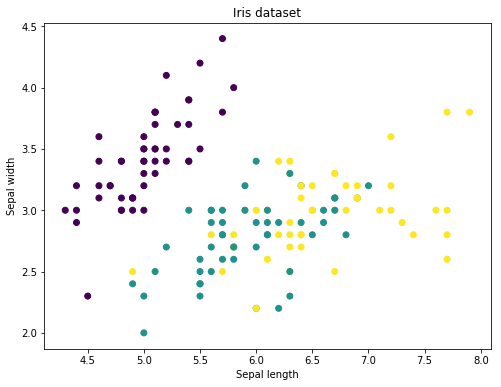

In [746]:
import matplotlib.pyplot as plt

# plot the original data
x, y, lab = data[:, 0], data[:, 1], labels

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=lab)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris dataset')


Suppose we are given a new point whose sepal length (`x`) and sepal width (`y`) are the following:

In [747]:
new_x, new_y = 6.5, 3.7

Let's plot it on the graph. What could its class be?

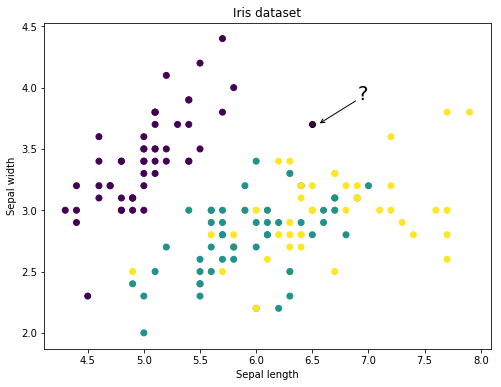

In [748]:
# plot the original data
x, y, lab = data[:, 0], data[:, 1], labels

plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=lab)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris dataset')

# put the new point on top
plt.scatter(new_x, new_y, c=0, cmap=None, edgecolor='k')
plt.annotate('?', (new_x+0.45, new_y+0.25), fontsize=20, horizontalalignment='center', verticalalignment='center')
plt.annotate("", xytext=(new_x+0.4, new_y+0.2), xy=(new_x+0.05, new_y), arrowprops=dict(arrowstyle="->"))


Our simple approach to predicting the new point's label is to find the point in the dataset which is closest to the new point, and copying its label.

In [749]:
# calculate the distance between the new point and each of the points in our labeled dataset
distances = np.sum((data[:,0:2] - [new_x, new_y])**2, axis=1)

# find the index of the point whose distance is lowest
closest_point = np.argmin(distances)

# take its label
new_label = labels[closest_point]

print('Predicted label: %d'%new_label)

Predicted label: 2


That's it! That is k-nearest neighbors where we set `k = 1`. If `k > 1`, we find the `k` closest points and take a vote among them.

We can now plot the newly-labeled point on top of the dataset.

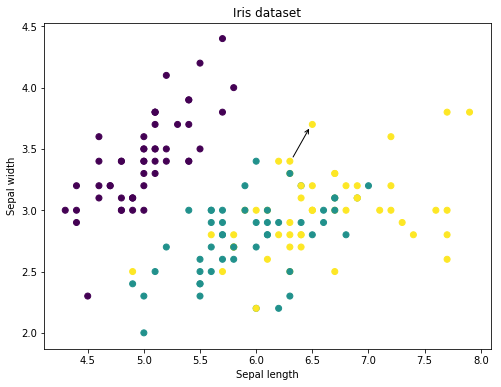

In [750]:
# append the newly labeled point in our dataset
x = np.append(x, new_x)
y = np.append(y, new_y)
lab = np.append(lab, new_label)

# scatter plot as before
plt.figure(figsize=(8, 6))
plt.scatter(x, y, c=lab)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris dataset')
plt.annotate("", xytext=(x[closest_point]+0.02, y[closest_point]+0.02), xy=(new_x-0.02, new_y-0.02), arrowprops=dict(arrowstyle="->"))


How accurate is k-nearest neighbors? We can answer this question with an experiment. Let's split the dataset into two: what we will call a "training set" and a "test set". For each point in the test set, we will find the closest point from the training set, and copy its label as our prediction for the test point. We will then compare our predictions to the actual labels in the test set, and measure our accuracy.

In [751]:
# how many samples to keep in the training set
n_train = 100

# split our dataset into training and test sets
train_data, train_labels = data[:n_train, 0:2], labels[:n_train]
test_data, test_labels = data[n_train:, 0:2], labels[n_train:]

Let's plot the reduced training set.

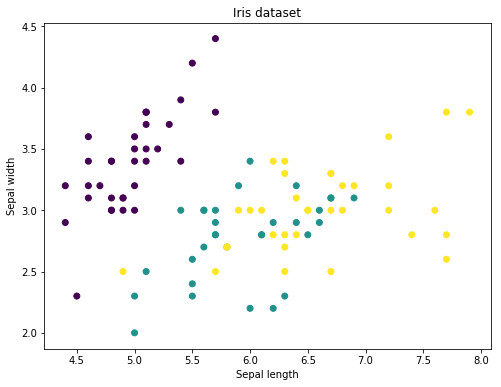

In [752]:
plt.figure(figsize=(8, 6))
plt.scatter(train_data[:,0], train_data[:,1], c=train_labels)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris dataset')

Now let's plot the unknown points on top of it. They are colored black.

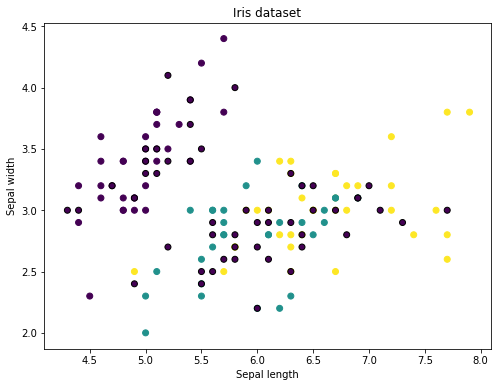

In [754]:
plt.figure(figsize=(8, 6))
plt.scatter(train_data[:,0], train_data[:,1], c=train_labels)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Iris dataset')
plt.scatter(test_data[:,0], test_data[:,1], c=[0]*len(test_labels), cmap=None, edgecolor='k')

Let's repeat our procedure from above, where we calculate the distances between each test point and each training point.

In [755]:
# list of each set of distances between each point in the test set and each point in the training set
distances = [ np.sum((train_data[:,0:2] - [x[0],x[1]])**2, axis=1) for x in test_data ]

# for each point in the test set, take the index in the training set of the point closest to it
closest_points = [ np.argmin(distance) for distance in distances ]

# copy the labels of those closest points as our prediction
new_labels = [train_labels[c] for c in closest_points]

How did we do?

In [756]:
results = (new_labels == test_labels)
num_correct = sum(results)
accuracy = num_correct / len(correct)
print("accuracy %0.2f" % accuracy)

accuracy 0.60


Our accuracy is 72%. Not too bad for such a simple method.

Let's try it for a more complicated dataset. MNIST

Not so good. 

What are the pros and cons of nearest-neighbor search?



We will need something better: neural network.

First let's introduce regression


## Neural networks

We are now going to innovate our linear regression in a few ways and turn it into a multiple-layer neural network!

First, let's start by adding another input variable, so that now are input is two dimensions. We'll go back to the Iris dataset, and pose the following problem: given the sepal length and sepal width (first two features), try to predict the petal length (third feature).

Load the data.

In [616]:
iris = load_iris()
data, labels = iris.data[:,0:2], iris.data[:,2]

num_samples = len(labels)  # size of our dataset

# shuffle the dataset
shuffle_order = np.random.permutation(num_samples)
data = data[shuffle_order, :]
labels = labels[shuffle_order]


Like the 1-dimensional problem previously, we can still do linear regression, except now we have two variables and therefore two weights as well. We have:

$$
f(X) = w_1 x_1 + w_2 x_2 + b 
$$

There are three parameters: w1, w2, b

We can look at it:
!download (5).png

For example, suppose set $w = [0.5, 0.3]$ and $b = 0.1$. We can visualize that function.

In [674]:
def weighted_sum(x, w, b):
    return b + np.dot(w, x)


# set our paramters
w = [0.5, 0.3]
b = 0.1

# for example, let's use the first data point
X, y = data, labels

pred_y = [weighted_sum(x, w, b) for x in X]
error = mse(pred_y, y)
print(error)
#print('predicted %0.2f, actual %0.2f, mse %0.2f'%(pred_y, y, error))


333.971


Like in the previous section, we can optimize our three parameters:

equations

In [ ]:
# implement optimization and graph

We can view our prediction surface:

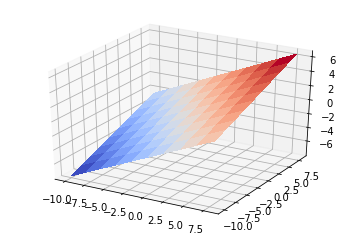

In [629]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(-10, 10, 2), np.arange(-10, 10, 2))
y = b + w[0]*x1 + w[1]*x2
ax.plot_surface(x1, x2, y, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)


Given a dataset, we can use this setup to do linear regression, just as we did in the case of the one-dimensional dataset a few cells above. In this case, we ae no longer able to visualize the loss surface, because our function has 3 parameters (w1, w2, and b) and therefore requires four dimensions to plot the loss surface with repsect to the parameters). But the regression would work just the same way.

But this isn't good enough because it's linear. (why)

So we introduce a non-linearity. One good one is a sigmoid function.

$$
z = b + \sum_i w_i x_i \\
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Let's implement the sigmoid function, and take a look at its graph.


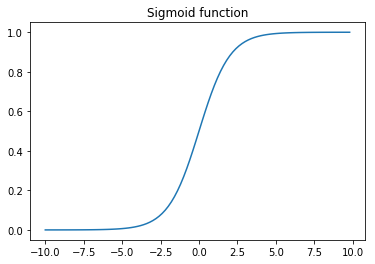

In [579]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x,sig)
plt.title('Sigmoid function')

!sigmoid

Basically it just squashes it.

we now modify our basic function in the following way: instead of just outputting $b + \sum_i w_i x_i$, we now pass that through the sigmoid function. In other words:

$$
z = w_1 x_1 + w_2 x_2 + b \\
y = \sigma(z) 
$$

In graphical terms, this looks like:

!download (6) copy.png

suppose we let

w = [0.5, 0.3]
b = 0.1


In [684]:
# reset our parameters
w = [0.5, 0.3]
b = 0.1

# let's use the first data point again
#x, y = data[0], labels[0]
X, y = data, labels

Z = [weighted_sum(x, w, b) for x in X]
y_pred = [sigmoid(z) for z in Z]
error = mse(y_pred, y)
print(error)
#print('predicted %0.2f, actual %0.2f, mse %0.2f'%(pred_y, y, error))


10.797170524615561


That migh look much worse, but we haven't optimized yet!

Given the above weights, we can take a look at the graph of our neuron's activity.

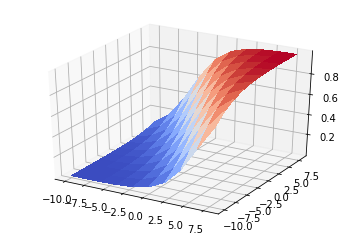

In [676]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x1, x2 = np.meshgrid(np.arange(-10, 10, 2), np.arange(-10, 10, 2))
y = sigmoid(b + w[0]*x1 + w[1]*x2)
ax.plot_surface(x1, x2, y, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)


//Now let's scale this up in two ways. We will add another layer to the network, and make the input have four variabls.

Noe let's add a hidden layer.

TODO: 
figure 2x3x1

we need to create weights.

In [637]:
W1 = np.random.randn(2, 3)
W2 = np.random.randn(3, 1)

In [685]:
X, y = data, labels

Z = [np.dot(x, W1) for x in X]
Z = [sigmoid(z) for z in Z]

#print("activation in hidden layer = ", z)

y_pred = [np.dot(z, W2) for z in Z]
error = mse(y_pred, y)

print(error)
#print('predicted %0.2f, actual %0.2f, mse %0.2f'%(pred_y, y, error))


2526.1826469876382


Does it match our actual output?

We can turn this into a class.

In [686]:
class Neural_Network(object):
    def __init__(self, n0, n1, n2):        
        self.n0 = n0
        self.n1 = n1
        self.n2 = n2
        
        # initialize weights
        self.W1 = np.random.randn(self.n0, self.n1)
        self.W2 = np.random.randn(self.n1 ,self.n2)
        
    def predict(self, x):
        z = np.dot(x, self.W1)
        z = sigmoid(z)
        y = np.dot(z, self.W2)
        return y
  

Instantiate.

In [640]:
net = Neural_Network(2, 3, 1)    

In [688]:
X, y = data, labels

y_pred = net.predict(X)

error = mse(y_pred, y)

#print('predicted %0.2f, actual %0.2f, mse %0.2f'%(pred_y, y, error))
print(error)
# normalize????????
#X = X/np.amax(X, axis=0)
#y = y/100 #Max test score is 100


1938.0372810520946


## Gradient descent

how do we get the gradient? do simplest one first (newton method)

463.88065533222476


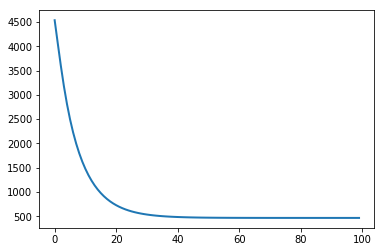

In [689]:
import itertools

def get_gradient(net, X, y):
    w_delta = 1e-8

    y_pred_current = net.predict(X)
    error_current = mse(y_pred_current, y)

    dw1, dw2 = np.zeros((net.n0, net.n1)), np.zeros((net.n1, net.n2))
    W1, W2 = np.copy(net.W1), np.copy(net.W2) 
    
    for i, j in itertools.product(range(net.n0), range(net.n1)):
        net.W1 = np.copy(W1)
        net.W1[i][j] += w_delta
        y_pred = net.predict(X)
        error = mse(y_pred, y)
        dw1[i][j] = (error - error_current) / w_delta

    for i, j in itertools.product(range(net.n1), range(net.n2)):
        net.W2 = np.copy(W2)
        net.W2[i][j] += w_delta
        y_pred = net.predict(X)
        error = mse(y_pred, y)
        dw2[i][j] = (error - error_current) / w_delta

    net.W1, net.W2 = np.copy(W1), np.copy(W2)

    return dw1, dw2


net = Neural_Network(2, 3, 1)    


X, y = data, labels


# normalize up top!

#X = X/np.amax(X, axis=0)
#y = y/np.amax(y, axis=0) #Max test score is 100


n_epochs = 100
learning_rate = 0.0001

errors = []
for i in range(n_epochs):
    dw1, dw2 = get_gradient(net, X, y)
    net.W1 = net.W1 - learning_rate * dw1
    net.W2 = net.W2 - learning_rate * dw2
    y_pred = net.predict(X)
    error = mse(y_pred, y)
    errors.append(error)
        

plt.plot(range(0, len(errors)), errors, linewidth=2)


y_pred = net.predict(X)
error = mse(y_pred, y)
print(error)


In [653]:
def sigmoid_deriv(z):
    return np.exp(-z) / ((1 + np.exp(-z))**2)


def get_gradient_2(net, X, y):
    #Compute derivative with respect to W and W2 for a given X and y:
    y_current = net.forward(X)

    delta3 = np.multiply(-(y-y_current), sigmoid_deriv(net.z3))
    #Add gradient of regularization term:
    dJdW2 = np.dot(net.a2.T, delta3) / X.shape[0]

    delta2 = np.dot(delta3, net.W2.T) * sigmoid_deriv(self.z2)
    #Add gradient of regularization term:
    dJdW1 = np.dot(X.T, delta2) / X.shape[0]
    return dJdW1, dJdW2

net = Neural_Network(2, 3, 1)    


n_epochs = 100
learning_rate = 0.1

errors = []
for i in range(n_epochs):
    dw1, dw2 = get_gradient_2(net, X, y)
    net.W1 = net.W1 - learning_rate * dw1
    net.W2 = net.W2 - learning_rate * dw2
    y_pred = net.predict(X)
    error = mse(y_pred, y)
    errors.append(error)
        

plt.plot(range(0, len(errors)), errors, linewidth=2)


NameError: name 'self' is not defined

In [ ]:
TODO softmax
classification


# introduce softmax / cross-entropy

Let's try IRIS

In [ ]:
Now let's do MNIST

it's slow

In [180]:

#import matplotlib.pyplot as plt
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.data[:, 2]
y = np.reshape(y, (len(y), 1))
X = X/np.amax(X, axis=0)
y = y/np.amax(y, axis=0)



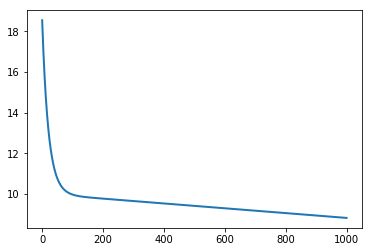

In [182]:
net = Neural_Network(2, 3, 1)    


X = X/np.amax(X, axis=0)
y = y/np.amax(y, axis=0)


n_epochs = 1000
learning_rate = 0.0001

errors = []
for i in range(n_epochs):
    dw1, dw2 = get_gradient(net, X, y)
    net.W1 = net.W1 - learning_rate * dw1
    net.W2 = net.W2 - learning_rate * dw2
    y_pred = net.predict(X)
    error = mse(y_pred, y)
    errors.append(error)
        

matplotlib.pyplot.plot(range(0, len(errors)), errors, linewidth=2)


In [195]:

#import matplotlib.pyplot as plt
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
labels = iris.target


# need to shuffle

shuffle_order = np.random.permutation(len(labels))
X = X[shuffle_order, :]
labels = labels[shuffle_order]


X = X/np.amax(X, axis=0)


In [196]:
y = np.zeros((labels.size, labels.max()+1))
y[np.arange(labels.size), labels] = 1


In [198]:
def softmax(y_pred, y_actual):
    return sum((y_actual-y_pred)**2)

# softmax
z = y_pred
z_exp = [math.exp(i) for i in z]

# categorical cross-entropy loss


n_classes = 3
net = Neural_Network(2, 3, n_classes)    


y_pred = net.predict(X)
print(y_pred)



[[-0.51250553 -2.39679166  0.47132639]
 [-0.54292477 -2.47303499  0.48257093]
 [-0.55697994 -2.50562414  0.47671609]
 [-0.54243528 -2.47390911  0.49015408]
 [-0.55213687 -2.49320486  0.47451724]
 [-0.55908867 -2.51360235  0.48657196]
 [-0.52475319 -2.42670532  0.47337532]
 [-0.5591054  -2.51077545  0.47657754]
 [-0.56853825 -2.53222927  0.47095282]
 [-0.55851974 -2.51438004  0.49412773]
 [-0.56489265 -2.52410012  0.47369404]
 [-0.56069049 -2.51390359  0.47398022]
 [-0.54406229 -2.47715577  0.48753925]
 [-0.5673997  -2.53386864  0.48595299]
 [-0.54730441 -2.48361278  0.48231971]
 [-0.52679816 -2.42900496  0.46322471]
 [-0.5659435  -2.52520093  0.46865578]
 [-0.58315287 -2.56865599  0.472252  ]
 [-0.57217905 -2.53740436  0.45834065]
 [-0.56331564 -2.5181134   0.46635092]
 [-0.52308866 -2.42336824  0.47596929]
 [-0.55432406 -2.50131154  0.48439205]
 [-0.51717542 -2.40794228  0.47115348]
 [-0.547788   -2.48270783  0.47476873]
 [-0.54766579 -2.47966852  0.46477622]
 [-0.52449637 -2.42350725

In [ ]:

def get_gradient(net, X, y):
    w_delta = 1e-8

    y_pred_current = net.predict(X)
    error_current = softmax(y_pred_current, y)

    dw1, dw2 = np.zeros((net.n0, net.n1)), np.zeros((net.n1, net.n2))
    W1, W2 = np.copy(net.W1), np.copy(net.W2) 
    
    for i, j in itertools.product(range(net.n0), range(net.n1)):
        net.W1 = np.copy(W1)
        net.W1[i][j] += w_delta
        y_pred = net.predict(X)
        error = softmax(y_pred, y)
        dw1[i][j] = (error - error_current) / w_delta

    for i, j in itertools.product(range(net.n1), range(net.n2)):
        net.W2 = np.copy(W2)
        net.W2[i][j] += w_delta
        y_pred = net.predict(X)
        error = softmax(y_pred, y)
        dw2[i][j] = (error - error_current) / w_delta

    net.W1, net.W2 = np.copy(W1), np.copy(W2)

    return dw1, dw2



n_epochs = 100
learning_rate = 0.1

errors = []
for i in range(n_epochs):
    dw1, dw2 = get_gradient(net, X, y)
    net.W1 = net.W1 - learning_rate * dw1
    net.W2 = net.W2 - learning_rate * dw2
    y_pred = net.predict(X)
    error = mse(y_pred, y)
    errors.append(error)
        

matplotlib.pyplot.plot(range(0, len(errors)), errors, linewidth=2)


In [ ]:
import numpy as np

class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(sum(self.W1**2)+sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        return dJdW1, dJdW2

    def costFunctionPrimeManual(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        J1 = self.costFunction(X,y)
        delta = 1e-8
        
        
        dJdW1 = np.zeros((self.inputLayerSize,self.hiddenLayerSize))
        dJdW2 = np.zeros((self.hiddenLayerSize,self.outputLayerSize))

        
        W1copy = np.copy(self.W1)
        W2copy = np.copy(self.W2)
        
        for i in range(self.inputLayerSize):
            for j in range(self.hiddenLayerSize):
                self.W1 = np.copy(W1copy)
                self.W1[i][j] += delta
                J2 = self.costFunction(X,y)
                dj2 = (J2-J1) / delta
                dJdW1[i][j] = dj2
                
        for i in range(self.hiddenLayerSize):
            for j in range(self.outputLayerSize):
                self.W2 = np.copy(W2copy)
                self.W2[i][j] += delta
                J2 = self.costFunction(X,y)
                dj2 = (J2-J1) / delta
                dJdW2[i][j] = dj2
           
        self.W1 = np.copy(W1copy)
        self.W2 = np.copy(W2copy)
        
       
        return dJdW1, dJdW2

    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
    
    

# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

# normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100


NN = Neural_Network()



learning_rate = 0.1

costs = []
for i in range(1000):
    dJdW1, dJdW2 = NN.costFunctionPrimeManual(X,y)
    NN.W1 = NN.W1 - learning_rate * dJdW1
    NN.W2 = NN.W2 - learning_rate * dJdW2
    cost3 = NN.costFunction(X, y)
    costs.append(cost3)
        

